# Nicolaus Copernicus University summer internship project 
## Natural Language Processing applied to ancient language texts

We aim to investigate the implementation of a general pipeline to extract qualitative and quantitative information from Latin texts employing ML algorithms. In particular, our approach focuses on detecting similarities between texts of the same author. For instance, it could
be beneficial to classify authors according to writing styles or historical ages, as well as to recognize the author of anonymous documents with a certain prpercentage. \\

Finally, we propose a network representation that aims to capture and represent these similarities, and we quantify the degree of relationship by computing a similarity index.

In [ ]:
#Install the necessary libraries
!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti" -O latin_bert.tar && rm -f /tmp/cookies.txt
!mkdir models
!mv latin_bert.tar models/
!cd models
!tar -xf models/latin_bert.tar
!git clone https://github.com/pietro-sillano/LatinBERT LatinBERT
!pip install cltk==1.0.16
!pip install pygame  beautifulsoup4==4.9.1 cltk nltk==3.6.2 future==0.18.2 numpy tensor2tensor PyYAML==5.4.1 tokenizers==0.8.1rc2 transformers==3.1.0 tqdm==4.48.2 Unidecode==1.1.1 gensim==3.8.3
!pip install --upgrade scikit-learn
!pip install --upgrade spacy
!pip install --upgrade spacy
!pip install umap-learn
!pip install umap-learn[plot]

--2021-08-18 18:33:36--  https://docs.google.com/uc?export=download&confirm=q_GP&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti
Resolving docs.google.com (docs.google.com)... 74.125.140.138, 74.125.140.100, 74.125.140.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.140.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-3c-docs.googleusercontent.com/docs/securesc/b8nmn1getfdmr8bhlpc85qb0lp159468/u23qpqdnvj01u0mulcrbe6j8kd1it2jb/1629311550000/09859182337762586004/09815500635337329626Z/1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti?e=download [following]
--2021-08-18 18:33:37--  https://doc-0s-3c-docs.googleusercontent.com/docs/securesc/b8nmn1getfdmr8bhlpc85qb0lp159468/u23qpqdnvj01u0mulcrbe6j8kd1it2jb/1629311550000/09859182337762586004/09815500635337329626Z/1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti?e=download
Resolving doc-0s-3c-docs.googleusercontent.com (doc-0s-3c-docs.googleusercontent.com)... 108.177.15.132, 2a00:1450:400c:c0c::84
Connecting

In [ ]:
#Import the necessary libraries
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import metrics
import pandas as pd
#import cltk
#from cltk import embeddings
import sys
import os
import umap
import umap.plot
import numpy as np
import networkx as nx
syspath = 'LatinBERT/'
if syspath not in sys.path:
    sys.path.append(syspath)

from cltk.data.fetch import FetchCorpus
from cltk.tokenizers.lat.lat import LatinWordTokenizer as WordTokenizer
from cltk.sentence.lat import LatinPunktSentenceTokenizer as SentenceTokenizer
from cltk import NLP

corpus_downloader = FetchCorpus(language="lat")
corpus_downloader.list_corpora
corpus_downloader.import_corpus("lat_models_cltk")

cltk_nlp = NLP(language="lat")

from latbert import LatinBERT


tokenizerPath = 'LatinBERT/latin.subword.encoder'
bertPath = 'latin_bert/'
bert=LatinBERT(tokenizerPath=tokenizerPath, bertPath=bertPath)

‎𐤀 CLTK version '1.0.16'.
Pipeline for language 'Latin' (ISO: 'lat'): `LatinNormalizeProcess`, `LatinStanzaProcess`, `LatinEmbeddingsProcess`, `StopsProcess`, `LatinNERProcess`, `LatinLexiconProcess`.


# NLP with Latin-Bert

In [ ]:
df=pd.read_csv('prose_by_authors')    #read the dataset 
df=df.drop(labels=[6,7,10], axis=0)   #6,7,10 give problem, I delete them
df=df.sample(frac=1)
df=df.reset_index()
df

,index,text,label,author,age
0,71,"Vos autem, patres conscripti, quo usque cuncta...",18,SALLUST,86-34 B.C
1,38,Primus ille et urbis et imperii conditor Romu...,11,FLORUS,2ND CENTURY A.D.
2,14,Erat idem temporis Sex. Pompeius frater qui cu...,4,CAESAR,100 – 44 B.C.
3,43,P. Scipio ad Numantiam corruptum superiorum du...,12,FRONTINUS,C.40-103 A.D.
4,66,Quadrimus patrem amisit. Duodecimum annum agen...,17,QUINTILIAN,C. 69 - AFTER 130
...,...,...,...,...,...
90,55,"Interfuit autem pugnae navali apud Salamina, q...",15,NEPOS,C.100-24 B.C.
91,94,"Vide, inquit Atticus, ne te fallat et novenae ...",23,VARRO,116-27 B.C.
92,62,"Ex hereditate quae mihi obvenit, emi proxime C...",16,PLINY MINOR,63-C.113 A.D.
93,82,Iam imprimebam epistulae signum: resolvenda es...,20,SENECA MINOR,C.4 B.C.-A.D. 65


In [14]:
#preprocessing
docs=[] 
docs_labels=[]                           
for i in range(len(df)):
  t=re.sub(r'[^\w\s]', '', df['text'][i])
  t=t.lower()
  docs.append(re.sub(r'[0-9]+', '', t))
  docs_labels.append((re.sub(r'[0-9]+', '', t),df['label'][i]))

In [15]:
#documents embedding with latin bert
bert_sents=bert.get_berts(docs,docs_labels)

In [16]:
#at each document corresponds a vector
vec=[]
for i in range(len(bert_sents)):
  vec.append(bert_sents[i][0][1])
X=np.array(vec)
np.shape(X)

(95, 768)

In [17]:
y=np.array(df['label'])      #labels
auth=df['author']      #authors

# Cosine similarity

In [18]:
cos=pd.DataFrame(metrics.pairwise.cosine_similarity(X))
cos

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94
0,1.000000,0.734287,0.695810,0.786632,0.690153,0.749644,0.739046,0.755317,0.724491,0.748136,0.790684,0.829955,0.752883,0.722271,0.751318,0.753919,0.770920,0.769574,0.750454,0.759360,0.789342,0.680114,0.743603,0.783107,0.772623,0.757310,0.665936,0.751813,0.676089,0.800548,0.684901,0.779517,0.853907,0.742009,0.741142,0.705841,0.683070,0.662685,0.716011,0.752569,...,0.739798,0.776354,0.765522,0.747104,0.730403,0.758294,0.755866,0.753418,0.736556,0.772532,0.755341,0.894782,0.923784,0.714580,0.754392,0.748445,0.724319,0.735834,0.732845,0.774515,0.756666,0.712654,0.922478,0.740691,0.883484,0.697751,0.767379,0.679960,0.784968,0.749011,0.755163,0.736178,0.721772,0.725455,0.793779,0.781760,0.729131,0.731267,0.772172,0.733196
1,0.734287,1.000000,0.727335,0.857459,0.785865,0.872651,0.874290,0.822548,0.784538,0.876054,0.794797,0.811851,0.814325,0.774695,0.873473,0.779056,0.785276,0.805586,0.823684,0.791601,0.823421,0.799528,0.718846,0.841968,0.841873,0.842412,0.777331,0.869154,0.845253,0.801010,0.739757,0.847729,0.735613,0.811594,0.834674,0.783654,0.770587,0.739198,0.839532,0.831652,...,0.776605,0.751519,0.749982,0.862480,0.734563,0.868991,0.846507,0.730156,0.830337,0.757130,0.786520,0.726100,0.745104,0.821450,0.755564,0.770198,0.779724,0.770357,0.787688,0.790960,0.838180,0.739395,0.747768,0.795754,0.776256,0.789042,0.858459,0.810953,0.853392,0.806138,0.784087,0.704466,0.709463,0.858015,0.750436,0.816916,0.807799,0.811829,0.784299,0.901475
2,0.695810,0.727335,1.000000,0.807041,0.664003,0.786542,0.682994,0.704860,0.665598,0.719591,0.664892,0.666813,0.695994,0.878735,0.799836,0.695111,0.668708,0.703852,0.898749,0.728051,0.858793,0.650660,0.904275,0.812020,0.683522,0.727677,0.632998,0.749572,0.711495,0.766064,0.669062,0.700358,0.727017,0.710212,0.750577,0.683556,0.677213,0.895894,0.785761,0.772828,...,0.853507,0.665053,0.674813,0.725488,0.660347,0.677941,0.672300,0.742285,0.666318,0.684790,0.741784,0.686784,0.673101,0.790998,0.728115,0.728960,0.880402,0.786473,0.760668,0.745289,0.719182,0.951708,0.657047,0.729167,0.666655,0.818693,0.713514,0.726056,0.748330,0.726687,0.666260,0.696740,0.660947,0.688332,0.734537,0.803187,0.735785,0.665990,0.693779,0.724326
3,0.786632,0.857459,0.807041,1.000000,0.814261,0.888090,0.838866,0.857757,0.822448,0.881173,0.794324,0.809259,0.830268,0.828655,0.873612,0.802288,0.781623,0.832776,0.879916,0.821858,0.883067,0.767636,0.807146,0.908385,0.815962,0.886095,0.708687,0.874676,0.821019,0.853786,0.808937,0.838616,0.782308,0.812859,0.882647,0.827954,0.815498,0.784041,0.852307,0.866227,...,0.839038,0.773337,0.778990,0.883000,0.760694,0.849861,0.847242,0.810913,0.814736,0.770788,0.775483,0.790324,0.798717,0.844726,0.770207,0.804391,0.851359,0.801384,0.827754,0.829258,0.861375,0.817494,0.769301,0.828687,0.803886,0.825189,0.849280,0.780891,0.901557,0.867528,0.788561,0.742112,0.755285,0.847372,0.800080,0.882040,0.819395,0.809376,0.791359,0.857029
4,0.690153,0.785865,0.664003,0.814261,1.000000,0.825227,0.801042,0.764311,0.905479,0.853884,0.755921,0.751526,0.790053,0.768728,0.799274,0.696471,0.741859,0.721556,0.771540,0.706068,0.747899,0.769303,0.715711,0.768686,0.724342,0.809174,0.671650,0.757502,0.852446,0.719667,0.713671,0.843811,0.653211,0.719456,0.796832,0.917295,0.918458,0.692459,0.790378,0.764028,...,0.771660,0.698915,0.676348,0.816999,0.663358,0.760184,0.896304,0.643339,0.763296,0.712281,0.795351,0.687401,0.693586,0.784268,0.732439,0.704047,0.761536,0.694432,0.682687,0.762237,0.741841,0.709818,0.715861,0.753189,0.670928,0.815660,0.794981,0.713560,0.871687,0.785861,0.662566,0.634605,0.630582,0.838037,0.714467,0.776079,0.665720,0.691533,0.671728,0.844471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [19]:
np.array(cos).min()

0.59793365

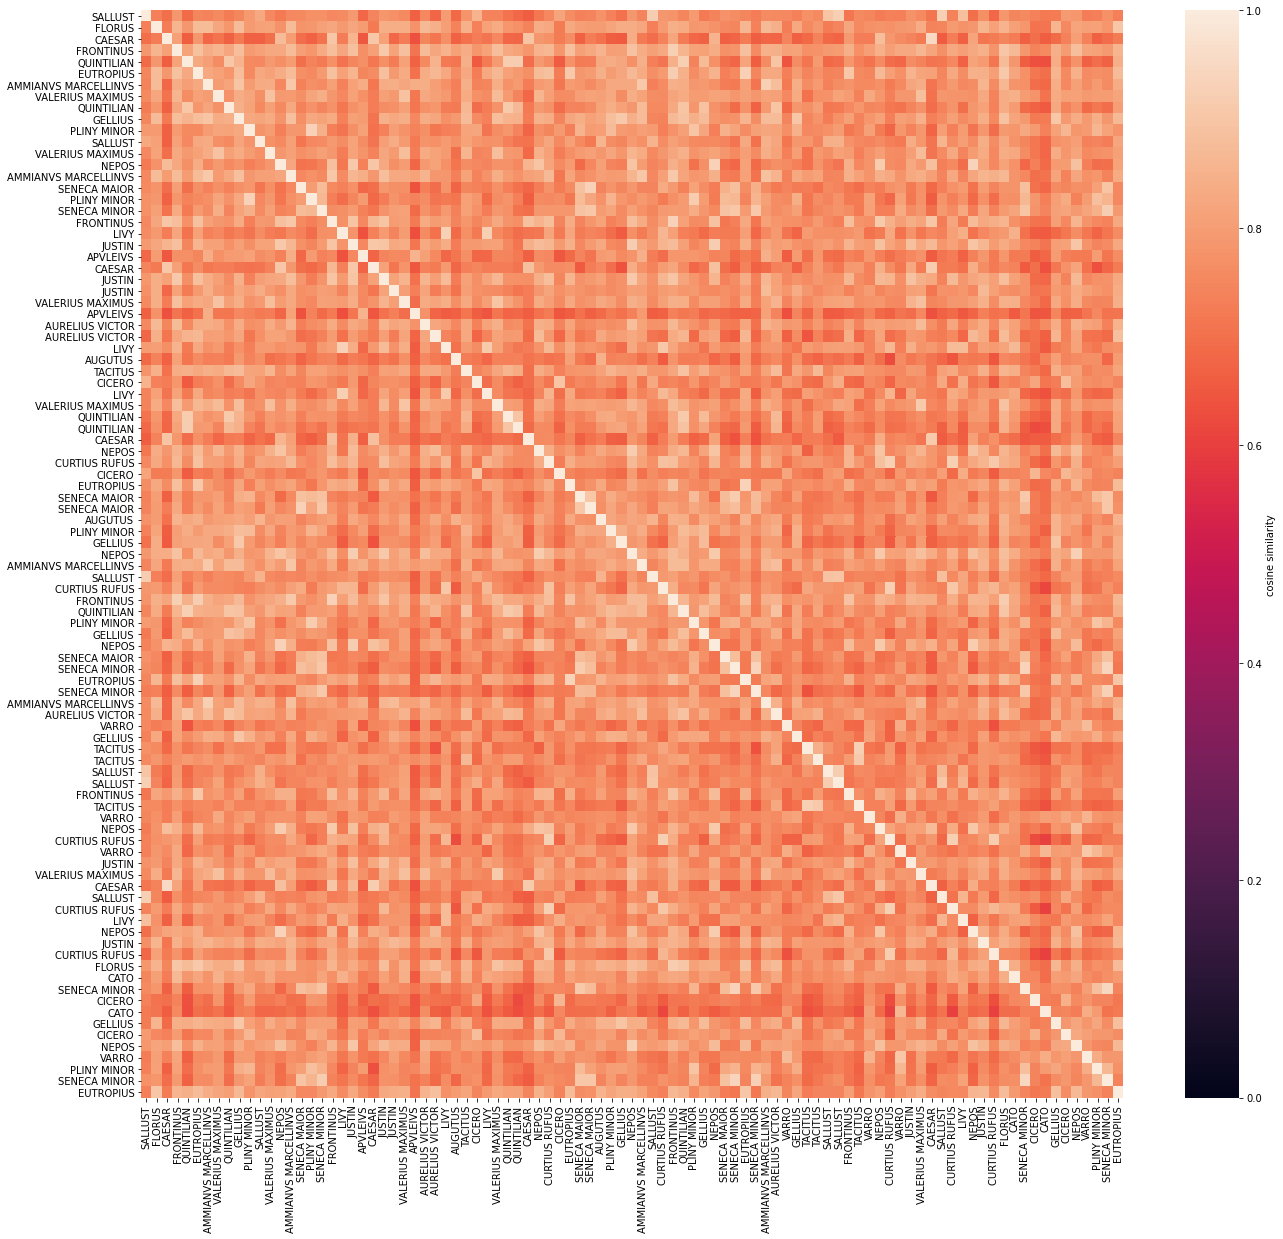

In [20]:
import seaborn as sns
#,xticklabels=ll
plt.figure(figsize=(22,20))
sns.heatmap(cos,vmin=0, vmax=1,xticklabels=auth,yticklabels=auth,cbar_kws={'label': 'cosine similarity'})

# Data visualization - UMAP

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


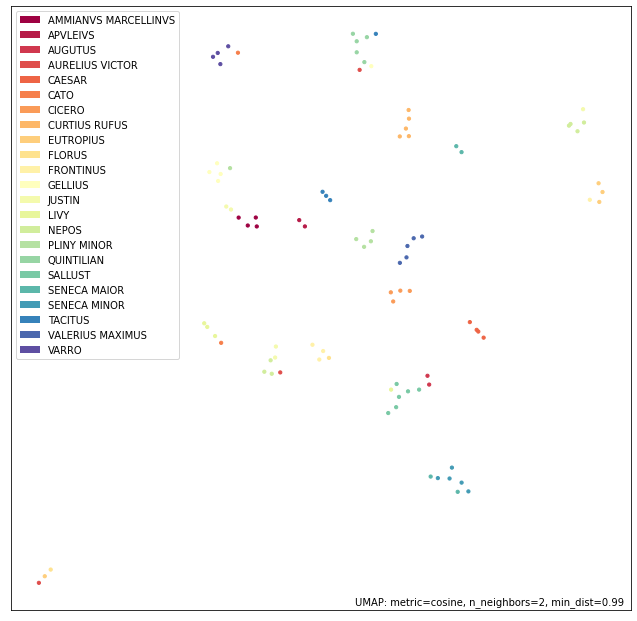

In [21]:
#dimensionality reduction with UMAP and graphical representation - plot 1
mapper = umap.UMAP(random_state=42, n_components=2, min_dist=0.99, metric='cosine', n_neighbors=2).fit(X)
umap.plot.points(mapper, labels=auth)

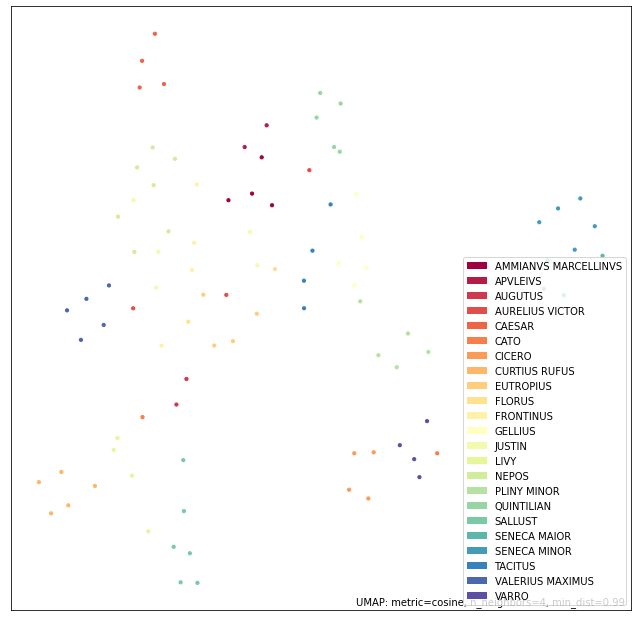

In [ ]:
#dimensionality reduction with UMAP and graphical representation - plot 2, different parameters
mapper = umap.UMAP(random_state=42, n_components=2, metric='cosine',n_neighbors=4, min_dist=0.99).fit(vec)
umap.plot.points(mapper, labels=df['author'])

# Multiclass classification

In [22]:
#import the machine learning libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
cos=MinMaxScaler().fit_transform(cos)

### Clustering with K-means

In [23]:
kmeans_labels = KMeans(random_state=0, n_clusters=23).fit_predict(X)  #mapper.transform(X)
kmeans_labels, y

(array([ 5, 11, 12,  3, 13, 14, 10, 18, 13, 11, 16, 22, 18,  0, 10,  1, 16,
        19, 12,  2,  0, 21, 12,  0, 22, 18, 21,  0,  3,  2, 14,  9,  7,  2,
         3, 13, 13, 12,  0,  8,  7, 14,  1,  1,  3, 11, 11,  0, 10,  5,  2,
         3, 13, 16, 11,  0, 19, 19, 14, 19, 10, 13,  4, 11, 20,  6,  5,  5,
        15, 20,  4,  0,  8,  4, 15, 18, 12,  5,  8,  5,  0, 22,  8,  3,  2,
        19, 17,  4, 11,  7,  0,  4, 16, 19, 14], dtype=int32),
 array([18, 11,  4, 12, 17, 10,  1, 22, 17, 13, 16, 18, 22, 15,  1, 19, 16,
        20, 12, 14,  7,  2,  4,  7,  7, 22,  2,  5,  5, 14,  3, 21,  8, 14,
        22, 17, 17,  4, 15,  9,  8, 10, 19, 19,  3, 16, 13, 15,  1, 18,  9,
        12, 17, 16, 13, 15, 19, 20, 10, 20,  1,  5, 23, 13, 21, 21, 18, 18,
        12, 21, 23, 15,  9, 23,  7, 22,  4, 18,  9, 14, 15,  7,  9, 11,  6,
        20,  8,  6, 13,  8, 15, 23, 16, 20, 10]))

In [24]:
rand_score(kmeans_labels,y)

0.9697648376259799

# Network of authors

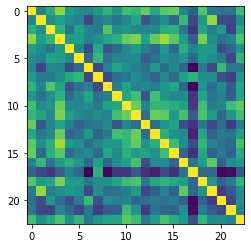

In [37]:
#we consider the k_means centers as nodes
kmeans = KMeans(n_clusters=23, random_state=0).fit(X)
cen=kmeans.cluster_centers_
np.shape(cen)
cos=pd.DataFrame(metrics.pairwise.cosine_similarity(cen))
plt.imshow(cos.to_numpy())

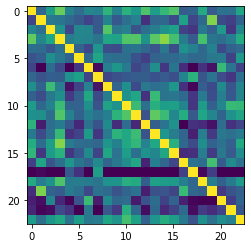

In [41]:
#rescale
cos=MinMaxScaler().fit_transform(cos)
plt.imshow(cos)

In [42]:
indexes = np.unique(y, return_index=True)[1]
auth_un=[y[index] for index in sorted(indexes)]
ll=df['author']
auth_unique=[ll[index] for index in sorted(indexes)]

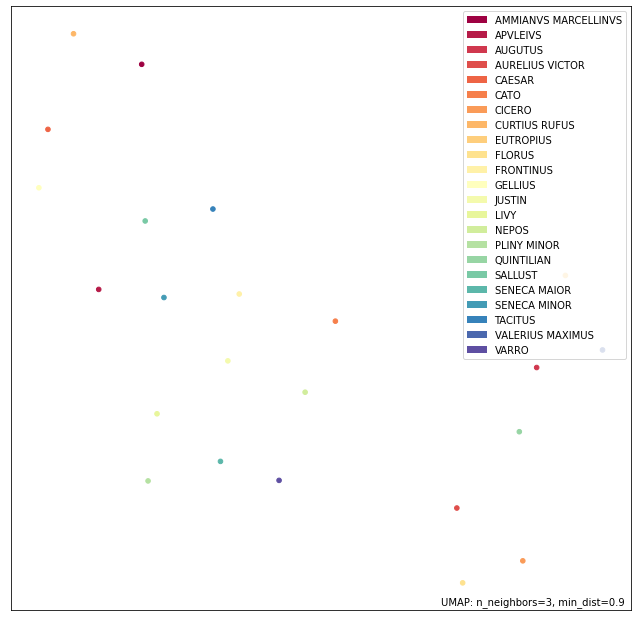

In [43]:
#dimensionality reduction with UMAP and graphical representation 
mapper = umap.UMAP(random_state=42, n_components=2, min_dist=0.9, metric='euclidean', n_neighbors=3).fit(cen)
#position - the same as umap
p=mapper.transform(cen)
#plot
umap.plot.points(mapper, labels=np.array(list(auth_unique)))

In [44]:
#prepare the edge for the network
li=[]
col=[]

N=np.shape(cos)[0]

for i in range(N):
    for j in range(N):
      if cos[i][j]!=0:
        li.append([i,j,cos[i][j]])

for i in range(len(li)):
    col.append(li[i][2])

G1 = nx.DiGraph() 
G1.add_weighted_edges_from(li)

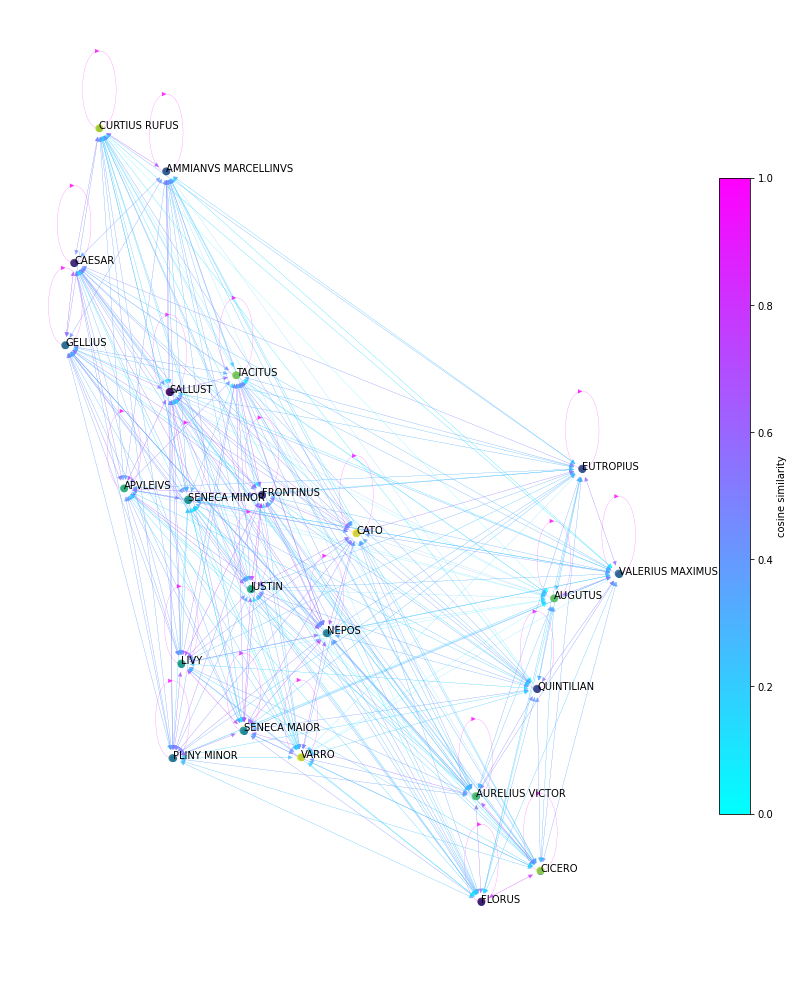

In [45]:
#Plotting network with colormap based on cosine similarity
plt.figure(figsize=(15, 18))

vmin = np.min(np.array(cos))
vmax = np.max(np.array(cos))

edge=nx.draw_networkx_edges(G1, p, alpha=0.8, edge_color=col, width=0.2,  edge_vmin=vmin, edge_vmax=vmax, edge_cmap=plt.cm.cool) 

nx.draw_networkx_nodes(G1, p, node_size=50.0, node_color=range(len(auth_unique)), alpha=0.8)  


sm = plt.cm.ScalarMappable(cmap=plt.cm.cool) 
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="cosine similarity")

plt.scatter(p[:,0], p[:,1])
n=auth_unique
for i, txt in enumerate(n):
    plt.annotate(txt, (p[i,0], p[i,1]))

plt.axis('off')
plt.show()

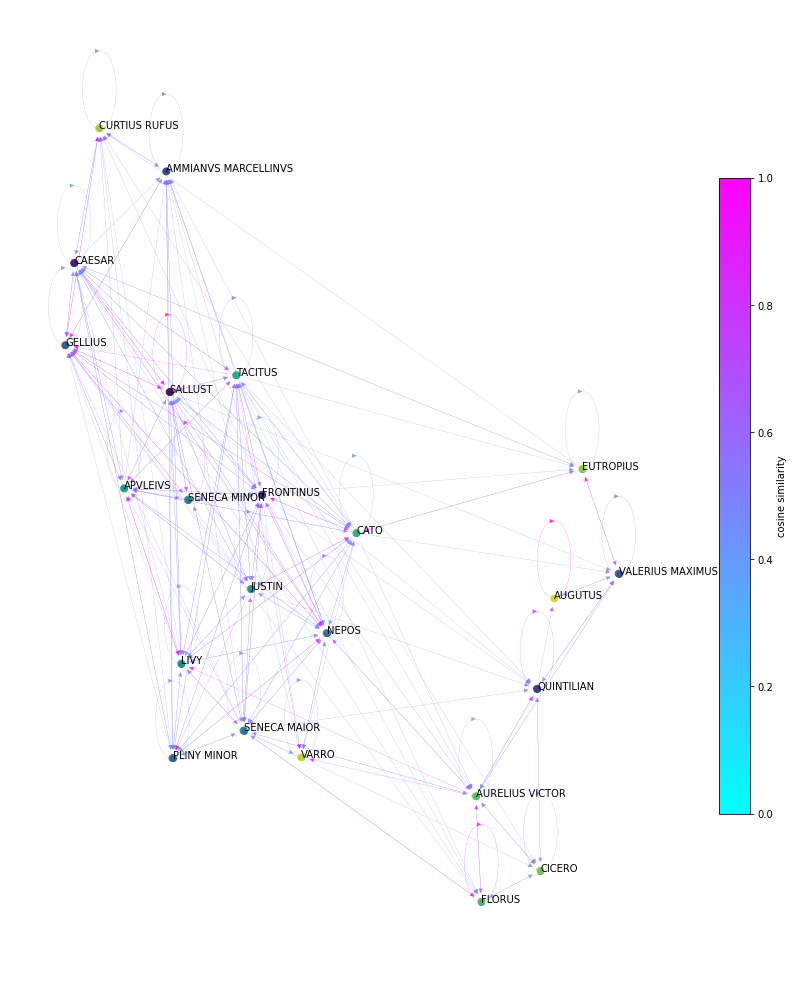

In [48]:
#setting a cutoff to see stronger relationships
cos[cos < .4] = 0
li=[]
col=[]

N=np.shape(cos)[0]

for i in range(N):
    for j in range(N):
      if cos[i][j]!=0:
        li.append([i,j,cos[i][j]])

for i in range(len(li)):
    col.append(li[i][2])

G1 = nx.DiGraph() 
G1.add_weighted_edges_from(li)

#Plotting network with colormap based on cosine similarity
plt.figure(figsize=(15, 18))

vmin = np.min(np.array(cos))
vmax = np.max(np.array(cos))

edge=nx.draw_networkx_edges(G1, p, alpha=0.8, edge_color=col, width=0.2,  edge_vmin=vmin, edge_vmax=vmax, edge_cmap=plt.cm.cool) 

nx.draw_networkx_nodes(G1, p, node_size=50.0, node_color=range(len(auth_unique)), alpha=0.8)  


sm = plt.cm.ScalarMappable(cmap=plt.cm.cool) #, norm=plt.Normalize(vmin=vmin, vmax=vmax)
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="cosine similarity")

plt.scatter(p[:,0], p[:,1])
n=auth_unique
for i, txt in enumerate(n):
    plt.annotate(txt, (p[i,0], p[i,1]))

plt.axis('off')
plt.show()